In [1]:
!git clone http://github.com/Zapy67/ATML-PA-4 test

fatal: destination path 'test' already exists and is not an empty directory.


In [4]:
!git pull http://github.com/Zapy67/ATML-PA-4 test

From http://github.com/Zapy67/ATML-PA-4
 * branch            test       -> FETCH_HEAD
Already up to date.


In [2]:
%cd test

/kaggle/working/test


In [4]:
!ls

'ATML - PA 4.pdf'   fedprox.ipynb       README.md     task4.ipynb
 data		    fedsam.ipynb        task1.ipynb
 fedgh.ipynb	    fedscaffold.ipynb   task2.ipynb
 fed_lib	    LICENSE	        task3.ipynb


#  FedSam & Local Optimization

In [5]:
import torch
import torch.nn as nn

In [10]:
!pip install fedlab

In [6]:
import fed_lib
import importlib
importlib.reload(fed_lib)

<module 'fed_lib' from '/kaggle/working/test/fed_lib/__init__.py'>

In [7]:
from fed_lib import fed_methods, fed_model, utils
importlib.reload(fed_methods)
importlib.reload(fed_model)
importlib.reload(utils)

10:01:43 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


<module 'fed_lib.utils' from '/kaggle/working/test/fed_lib/utils.py'>

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
trainset, testset = utils.get_cifar10()

In [10]:
import matplotlib.pyplot as plt
def plot_fed_vs_central_acc(metrics, title="FedAvg vs Central Test Accuracy"):
    """
    Args:
        metrics (dict): self.round_metrics dictionary from FedSGD.
    """
    fed_acc = metrics.get('fed_test_acc', [])
    central_acc = metrics.get('central_test_acc', [])

    rounds = list(range(1, len(fed_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, fed_acc, marker='o', label='FedAvg (Server) Accuracy')
    plt.plot(rounds, central_acc, marker='s', label='Central Model Accuracy')

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [11]:
def fed_sam_exp(lr=1e-3, num_steps=5, num_clients=5, partition="dirichlet", alpha=10000,device=device, global_runs=20, verbose=False, sampling_frac=1.0, rho=1e-3):
        fed = fed_model.Federation(num_clients=num_clients, federate_method=None, partition=partition, domains=None, alpha=alpha, device=device, batch_size=64, pin_memory=True, num_workers=2)
        client_loaders = fed.client_dataloaders
        client_weights = [len(client.dataset.indices)/len(fed.centralized_train_loader) for client in client_loaders]
        
        fed_meth = fed_methods.FedSAM(local_epochs=1, aggregation_steps=num_steps, client_weights=client_weights, sample_fraction=sampling_frac, rho=rho)
        fed.set_method(fed_meth)
        fed.train(global_runs, lr=lr, verbose=verbose, train_central=False)

        return fed

In [12]:
import matplotlib.pyplot as plt

def plot_metrics(metrics:dict, title:str, label: str, label_desc:str):
    metric_map = {
        'fed_test_acc': 'Test Accuracy',
        'fed_test_loss': 'Test Loss',
        'client_drift': 'Client Drift (Norm)'
    }
    metric_order = ['fed_test_acc', 'fed_test_loss', 'client_drift']
    k_values = sorted(metrics.keys())

    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    fig.suptitle(title, fontsize=14)

    for i, metric_key in enumerate(metric_order):
        ax = axes[i]
        for k in k_values:
            values = metrics[k][metric_key]
            rounds = list(range(1, len(values) + 1))
            ax.plot(rounds, values, label=f'{label}={k}')
            
        ax.set_ylabel(metric_map[metric_key])
        ax.grid(axis='y', linestyle='--', alpha=0.6)    
        ax.legend(title=f'{label_desc} ({label})', loc='upper left')
            
    axes[-1].set_xlabel('Global Round')
    plt.show()

In [ ]:
#experimental setup 1.
from IPython.display import clear_output
metrics_exp_1 = {}
total_samples = len(trainset.dataset)
for alpha in [1e-4, 1e-2, 1e-1, 1, 10]: 
    f = fed_sam_exp(lr=1e-2, rho=2e-3,num_clients=5,num_steps=75, global_runs=30, sampling_frac=1.0, alpha=alpha)
    metrics_exp_1[alpha] = f.federated_method.round_metrics
    clear_output(wait=True)

/usr/local/lib/python3.11/dist-packages/fedlab/utils/dataset/functional.py:175: RuntimeWarning: invalid value encountered in cast
  proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
/usr/local/lib/python3.11/dist-packages/fedlab/utils/dataset/functional.py:172: RuntimeWarning: invalid value encountered in scalar multiply
  [p * (len(idx_j) < num_samples / num_clients) for p, idx_j in
/usr/local/lib/python3.11/dist-packages/fedlab/utils/dataset/functional.py:174: RuntimeWarning: invalid value encountered in divide
  proportions = proportions / proportions.sum()



--- Round 1/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 4.058106e-01
Client Drift Std: 1.465581e-01
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.303784e-01
Client Number: 2 Drift :3.304560e-01
Client Number: 0 Drift :3.312770e-01
Client Number: 1 Drift :3.380712e-01
Client Number: 4 Drift :6.988705e-01

Evaluate on round 1:


FedSAM  | Test Loss: 2.2300, Test Acc: 28.67%

--- Round 2/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 4.047601e-01
Client Drift Std: 4.211825e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.795784e-01
Client Number: 3 Drift :3.819864e-01
Client Number: 2 Drift :3.866152e-01
Client Number: 1 Drift :3.868048e-01
Client Number: 4 Drift :4.888157e-01

Evaluate on round 2:


FedSAM  | Test Loss: 2.3550, Test Acc: 33.30%

--- Round 3/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.991210e-01
Client Drift Std: 1.218724e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.879039e-01
Client Number: 0 Drift :3.924240e-01
Client Number: 2 Drift :3.961027e-01
Client Number: 1 Drift :3.964767e-01
Client Number: 4 Drift :4.226978e-01

Evaluate on round 3:


FedSAM  | Test Loss: 2.3429, Test Acc: 37.45%

--- Round 4/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.914997e-01
Client Drift Std: 3.666218e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.865233e-01
Client Number: 3 Drift :3.881330e-01
Client Number: 4 Drift :3.926098e-01
Client Number: 1 Drift :3.937536e-01
Client Number: 2 Drift :3.964790e-01

Evaluate on round 4:


FedSAM  | Test Loss: 2.4024, Test Acc: 38.36%

--- Round 5/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.856893e-01
Client Drift Std: 9.138494e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.691131e-01
Client Number: 0 Drift :3.843212e-01
Client Number: 3 Drift :3.871569e-01
Client Number: 1 Drift :3.926973e-01
Client Number: 2 Drift :3.951578e-01

Evaluate on round 5:


FedSAM  | Test Loss: 2.4113, Test Acc: 38.93%

--- Round 6/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.818146e-01
Client Drift Std: 1.278633e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.569693e-01
Client Number: 0 Drift :3.821946e-01
Client Number: 1 Drift :3.893939e-01
Client Number: 2 Drift :3.902113e-01
Client Number: 3 Drift :3.903040e-01

Evaluate on round 6:


FedSAM  | Test Loss: 2.2840, Test Acc: 42.70%

--- Round 7/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.782140e-01
Client Drift Std: 1.931668e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.403980e-01
Client Number: 0 Drift :3.819394e-01
Client Number: 3 Drift :3.855234e-01
Client Number: 2 Drift :3.894023e-01
Client Number: 1 Drift :3.938068e-01

Evaluate on round 7:


FedSAM  | Test Loss: 2.5168, Test Acc: 40.43%

--- Round 8/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.765907e-01
Client Drift Std: 2.469433e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.277194e-01
Client Number: 3 Drift :3.821620e-01
Client Number: 0 Drift :3.893977e-01
Client Number: 2 Drift :3.912524e-01
Client Number: 1 Drift :3.924220e-01

Evaluate on round 8:


FedSAM  | Test Loss: 2.3937, Test Acc: 42.09%

--- Round 9/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.730552e-01
Client Drift Std: 2.603427e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.213373e-01
Client Number: 0 Drift :3.824224e-01
Client Number: 3 Drift :3.833437e-01
Client Number: 2 Drift :3.872719e-01
Client Number: 1 Drift :3.909007e-01

Evaluate on round 9:


FedSAM  | Test Loss: 2.5342, Test Acc: 41.35%

--- Round 10/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.678063e-01
Client Drift Std: 3.118926e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.055612e-01
Client Number: 0 Drift :3.813317e-01
Client Number: 3 Drift :3.818086e-01
Client Number: 2 Drift :3.831976e-01
Client Number: 1 Drift :3.871325e-01

Evaluate on round 10:


FedSAM  | Test Loss: 2.3387, Test Acc: 43.55%

--- Round 11/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.651372e-01
Client Drift Std: 2.954516e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.063495e-01
Client Number: 0 Drift :3.757287e-01
Client Number: 3 Drift :3.776056e-01
Client Number: 2 Drift :3.818373e-01
Client Number: 1 Drift :3.841650e-01

Evaluate on round 11:


FedSAM  | Test Loss: 2.3406, Test Acc: 42.85%

--- Round 12/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.623499e-01
Client Drift Std: 3.204959e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.988605e-01
Client Number: 0 Drift :3.732237e-01
Client Number: 3 Drift :3.740497e-01
Client Number: 2 Drift :3.802786e-01
Client Number: 1 Drift :3.853372e-01

Evaluate on round 12:


FedSAM  | Test Loss: 2.3450, Test Acc: 43.57%

--- Round 13/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.607580e-01
Client Drift Std: 3.387178e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.933276e-01
Client Number: 0 Drift :3.724699e-01
Client Number: 3 Drift :3.767729e-01
Client Number: 2 Drift :3.786361e-01
Client Number: 1 Drift :3.825835e-01

Evaluate on round 13:


FedSAM  | Test Loss: 2.1876, Test Acc: 45.06%

--- Round 14/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.597888e-01
Client Drift Std: 3.019427e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.997767e-01
Client Number: 0 Drift :3.694077e-01
Client Number: 2 Drift :3.738798e-01
Client Number: 3 Drift :3.760690e-01
Client Number: 1 Drift :3.798110e-01

Evaluate on round 14:


FedSAM  | Test Loss: 2.4319, Test Acc: 42.57%

--- Round 15/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.605702e-01
Client Drift Std: 3.670497e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.874586e-01
Client Number: 3 Drift :3.734970e-01
Client Number: 1 Drift :3.784800e-01
Client Number: 0 Drift :3.795265e-01
Client Number: 2 Drift :3.838888e-01

Evaluate on round 15:


FedSAM  | Test Loss: 2.4213, Test Acc: 43.24%

--- Round 16/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.572147e-01
Client Drift Std: 3.183652e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.938412e-01
Client Number: 3 Drift :3.688193e-01
Client Number: 0 Drift :3.714074e-01
Client Number: 2 Drift :3.738185e-01
Client Number: 1 Drift :3.781871e-01

Evaluate on round 16:


FedSAM  | Test Loss: 2.4546, Test Acc: 39.83%

--- Round 17/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.530866e-01
Client Drift Std: 3.458102e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.842757e-01
Client Number: 3 Drift :3.638349e-01
Client Number: 0 Drift :3.707431e-01
Client Number: 1 Drift :3.727043e-01
Client Number: 2 Drift :3.738750e-01

Evaluate on round 17:


FedSAM  | Test Loss: 2.2784, Test Acc: 44.03%

--- Round 18/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.519310e-01
Client Drift Std: 3.772503e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.766668e-01
Client Number: 0 Drift :3.659140e-01
Client Number: 1 Drift :3.715308e-01
Client Number: 3 Drift :3.715784e-01
Client Number: 2 Drift :3.739649e-01

Evaluate on round 18:


FedSAM  | Test Loss: 2.3351, Test Acc: 44.38%

--- Round 19/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.540781e-01
Client Drift Std: 3.654800e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.820212e-01
Client Number: 3 Drift :3.651188e-01
Client Number: 0 Drift :3.658197e-01
Client Number: 2 Drift :3.761822e-01
Client Number: 1 Drift :3.812484e-01

Evaluate on round 19:


FedSAM  | Test Loss: 2.2907, Test Acc: 45.02%

--- Round 20/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.578343e-01
Client Drift Std: 3.886808e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.804724e-01
Client Number: 3 Drift :3.703788e-01
Client Number: 1 Drift :3.767513e-01
Client Number: 2 Drift :3.805318e-01
Client Number: 0 Drift :3.810375e-01

Evaluate on round 20:


FedSAM  | Test Loss: 2.4009, Test Acc: 42.64%

--- Round 21/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.534320e-01
Client Drift Std: 3.433210e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.850505e-01
Client Number: 3 Drift :3.674507e-01
Client Number: 0 Drift :3.674663e-01
Client Number: 1 Drift :3.712762e-01
Client Number: 2 Drift :3.759162e-01

Evaluate on round 21:


FedSAM  | Test Loss: 2.1758, Test Acc: 45.47%

--- Round 22/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.510633e-01
Client Drift Std: 3.957923e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.719766e-01
Client Number: 2 Drift :3.679646e-01
Client Number: 0 Drift :3.704953e-01
Client Number: 3 Drift :3.718511e-01
Client Number: 1 Drift :3.730289e-01

Evaluate on round 22:


FedSAM  | Test Loss: 2.1958, Test Acc: 45.67%

--- Round 23/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.479714e-01
Client Drift Std: 3.727693e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.735589e-01
Client Number: 3 Drift :3.637867e-01
Client Number: 0 Drift :3.647837e-01
Client Number: 1 Drift :3.673034e-01
Client Number: 2 Drift :3.704242e-01

Evaluate on round 23:


FedSAM  | Test Loss: 2.3188, Test Acc: 44.16%

--- Round 24/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.505879e-01
Client Drift Std: 4.319141e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.646763e-01
Client Number: 0 Drift :3.654169e-01
Client Number: 3 Drift :3.696360e-01
Client Number: 2 Drift :3.743519e-01
Client Number: 1 Drift :3.788585e-01

Evaluate on round 24:


FedSAM  | Test Loss: 2.2215, Test Acc: 46.18%

--- Round 25/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.503744e-01
Client Drift Std: 4.301416e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.644762e-01
Client Number: 1 Drift :3.676796e-01
Client Number: 0 Drift :3.718891e-01
Client Number: 3 Drift :3.729012e-01
Client Number: 2 Drift :3.749258e-01

Evaluate on round 25:


FedSAM  | Test Loss: 2.1994, Test Acc: 46.03%

--- Round 26/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.477740e-01
Client Drift Std: 4.002601e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.682194e-01
Client Number: 3 Drift :3.599604e-01
Client Number: 0 Drift :3.665677e-01
Client Number: 2 Drift :3.720074e-01
Client Number: 1 Drift :3.721154e-01

Evaluate on round 26:


FedSAM  | Test Loss: 2.0481, Test Acc: 47.11%

--- Round 27/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.445957e-01
Client Drift Std: 3.834264e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.688873e-01
Client Number: 0 Drift :3.549421e-01
Client Number: 3 Drift :3.588420e-01
Client Number: 2 Drift :3.690110e-01
Client Number: 1 Drift :3.712963e-01

Evaluate on round 27:


FedSAM  | Test Loss: 2.0908, Test Acc: 47.46%

--- Round 28/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.452420e-01
Client Drift Std: 3.863552e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.680555e-01
Client Number: 0 Drift :3.619746e-01
Client Number: 3 Drift :3.632331e-01
Client Number: 2 Drift :3.659505e-01
Client Number: 1 Drift :3.669966e-01

Evaluate on round 28:


FedSAM  | Test Loss: 2.2805, Test Acc: 45.88%

--- Round 29/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.446889e-01
Client Drift Std: 3.978219e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.670934e-01
Client Number: 0 Drift :3.552736e-01
Client Number: 3 Drift :3.572936e-01
Client Number: 2 Drift :3.634913e-01
Client Number: 1 Drift :3.802924e-01

Evaluate on round 29:


FedSAM  | Test Loss: 2.1075, Test Acc: 45.08%

--- Round 30/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.420449e-01
Client Drift Std: 4.052299e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :2.612533e-01
Client Number: 3 Drift :3.582025e-01
Client Number: 0 Drift :3.604428e-01
Client Number: 2 Drift :3.624391e-01
Client Number: 1 Drift :3.678868e-01

Evaluate on round 30:


FedSAM  | Test Loss: 2.1561, Test Acc: 46.21%
Training Complete!


FedSAM  | Test Loss: 2.1561, Test Acc: 46.21%


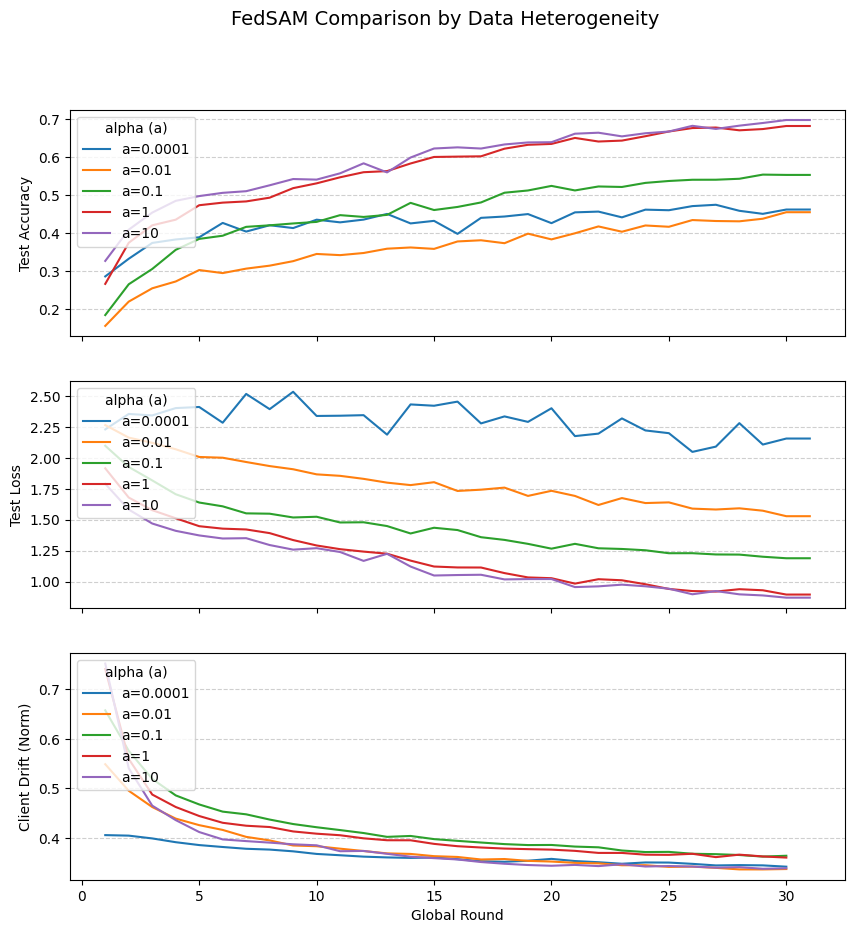

In [21]:
plot_metrics(metrics_exp_1, "FedSAM Comparison by Data Heterogeneity", label="a", label_desc="alpha")